# Table of Contents

### 1. Importing libraries and data
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing the Olist data

## 1. Importing libraries and data

In [90]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight') # styling option

In [91]:
# Define path

path = r'C:\Users\radav\OneDrive\Documents\Career Foundry\Data Analytics\Immersion\Achievement 6 Advanced Analytics and Dashboard Design\Olist'

In [92]:
# Import Olist data

df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'orders_merged.csv'), index_col=[0])

In [93]:
# Check dataset

df.head()

,order_id,customer_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,payment_sequential,payment_type,payment_installments,payment_value,act_delivery_days,seller_delivery_days,carrier_delivery_days,est_less_act_delivery_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,4.0,1,credit_card,1,18.12,8.0,2.0,6.0,7.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,4.0,3,voucher,1,2.00,8.0,2.0,6.0,7.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,4.0,2,voucher,1,18.59,8.0,2.0,6.0,7.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,4.0,1,boleto,1,141.46,12.0,0.0,12.0,5.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,5.0,1,credit_card,3,179.12,9.0,0.0,9.0,17.0


In [94]:
df.shape

(104477, 18)

## 2. Subsetting, wrangling, and cleaning time-series data

In [95]:
# Subset columns for time-series analysis of monthly Olist sales revenue from orders

df = df[['order_approved_at','payment_value']]

In [96]:
# Re-check output

df.head()

,order_approved_at,payment_value
0,2017-10-02 11:07:15,18.12
1,2017-10-02 11:07:15,2.00
2,2017-10-02 11:07:15,18.59
3,2018-07-26 03:24:27,141.46
4,2018-08-08 08:55:23,179.12


In [97]:
df.shape

(104477, 2)

In [98]:
df.dtypes

order_approved_at     object
payment_value        float64
dtype: object

In [99]:
# Convert the date columns to date format

columns = ['order_approved_at']
df[columns] = df[columns].apply(pd.to_datetime)

In [100]:
# Re-check data types

df.dtypes

order_approved_at    datetime64[ns]
payment_value               float64
dtype: object

In [124]:
# Exclude data before 2017 and 9/18 month since this appears to be incomplete order data

df_sub = df.loc[(df['order_approved_at'] >= '2017-01') & (df['order_approved_at'] < '2018-07')].reset_index(drop=True)

In [125]:
# Set the "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['order_approved_at']) # Create a datetime column
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe
df_sub.drop(['order_approved_at'], axis=1, inplace=True) # Drop the 'order_approved_at' column
df_sub.head()

,payment_value
datetime,
2017-10-02 11:07:15,18.12
2017-10-02 11:07:15,2.00
2017-10-02 11:07:15,18.59
2017-11-18 19:45:59,72.20
2018-02-13 22:20:29,28.62


In [126]:
# Convert data to weekly format

df_resampled = df_sub.resample('W-MON', label='left', closed='left').sum()

In [127]:
df_resampled.head()

,payment_value
datetime,
2017-01-02,3649.83
2017-01-09,13164.71
2017-01-16,28442.02
2017-01-23,63213.05
2017-01-30,82917.67


In [128]:
df_resampled.shape

(78, 1)

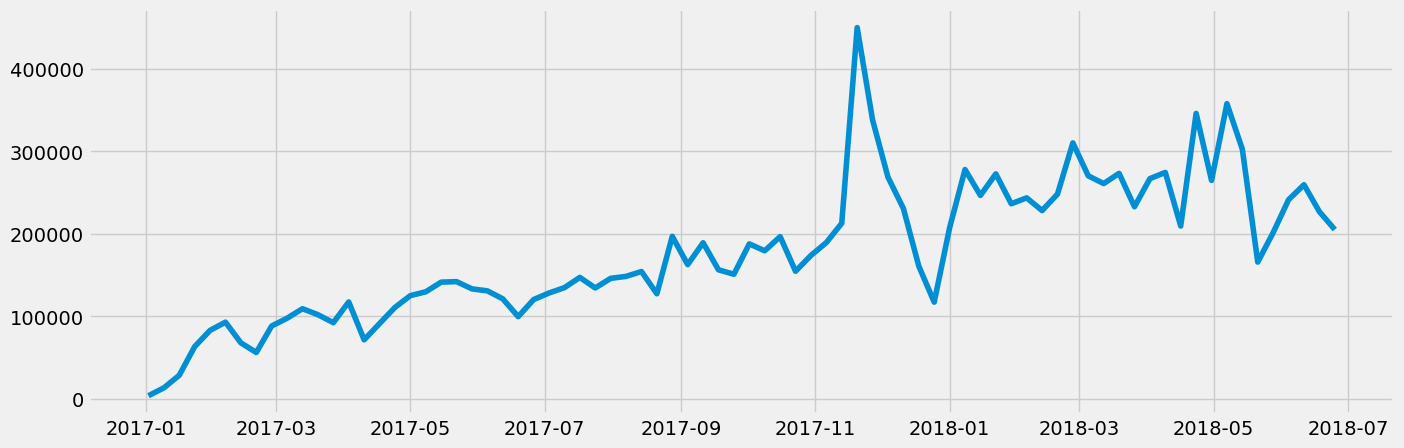

In [129]:
# Plot the data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_resampled)

## 3. Time-series analysis: decomposition

#### Requires 2 years of data for decomposition analysis to be run